In [2]:
import pandas as pd
import tensorflow_hub as hub
import numpy as np
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time


In [3]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [4]:
def plot_similarity(labels, corr): 
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=90)
  g.set_title("Semantic Textual Similarity")
    

In [5]:
# https://stackoverflow.com/questions/48092772/add-operation-to-graph-without-with-as-clause
graph = tf.Graph()
cm = graph.as_default()   
cm.__enter__()
# module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" 
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" 
#@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url, trainable=True)

session = tf.Session(graph=graph)
session.run(tf.global_variables_initializer())
session.run(tf.tables_initializer())
input1 = tf.placeholder(tf.string, shape=(None))
emb = embed(input1)


def encode(texts):   
    emb1 = session.run([emb], feed_dict={ input1: texts })
    return emb1

#warm up
_ = encode(["sasha", "miko"])

INFO:tensorflow:Using /var/folders/xn/dh4vn2gx4x36vh0x051kpw1m0000gn/T/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/3'.
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 10.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 40.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 80.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 100.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 120.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 130.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 150.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 180.00MB
INFO:tensor

In [6]:
def sim_approx(texts1, texts2):
           
    input1 = tf.placeholder(tf.string, shape=(None))
    input2 = tf.placeholder(tf.string, shape=(None))
    encode1 = embed(input1)
    encode2 = embed(input2)
    
    with tf.Session(graph=graph) as session:  
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        emb1, emb2 = session.run([encode1, encode2], feed_dict={input1: texts1, input2: texts2})
        #The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of two sentences can be trivially computed as the inner product of the encodings.
        sims = np.inner(emb1, emb2)
    return sims, emb1, emb2
    


In [7]:
def sim_exact(texts1, texts2):
    input1 = tf.placeholder(tf.string, shape=(None))
    input2 = tf.placeholder(tf.string, shape=(None))

    encode1 = tf.nn.l2_normalize(embed(input1), axis=1)
    encode2 = tf.nn.l2_normalize(embed(input2), axis=1)
    cosine_similarities = tf.reduce_sum(tf.multiply(encode1, encode2), axis=1)
    clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
    sim_scores = 1.0 - tf.acos(clip_cosine_similarities)
    
    with tf.Session(graph=graph) as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
  
        emb1, emb2, scores = session.run([encode1, encode2, sim_scores], 
                                         feed_dict={ input1: texts1,
                                                     input2: texts2 })
          
    return scores, emb1, emb2

In [16]:
def sim_exact_cross(embs1, embs2):
    input1 = tf.placeholder(tf.float64, shape=(None))
    input2 = tf.placeholder(tf.float64, shape=(None))

    norm1 = tf.nn.l2_normalize(input1, axis=1)
    norm2 = tf.nn.l2_normalize(input2, axis=1)
    cosine_similarities = tf.tensordot(norm1, norm2, axes=((1),(1)))
#     cosine_similarities = tf.reduce_sum(vectorsdot, axis=1)
    clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
    angular_dist = 1.0 - tf.acos(clip_cosine_similarities)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
  
        norm1, norm2, angdist, cossim = session.run([norm1, norm2, angular_dist, cosine_similarities], 
                                         feed_dict={ input1: embs1,
                                                     input2: embs2 })
          
    return angdist, cossim

In [9]:
# def encode(texts):
#     input1 = tf.placeholder(tf.string, shape=(None))
#     emb = embed(input1)
    
#     with tf.Session(graph=graph) as session:
#         session.run(tf.global_variables_initializer())
#         session.run(tf.tables_initializer())
  
#         emb1 = session.run([emb], feed_dict={ input1: texts })

In [10]:
messages = ["qewwed", "qewweda", "cvxcvds", "cvxcvdsw"]

In [11]:
messages = ["jeans", "denim", "pants", "trousers",
            "package", "parcel", 
            "hot", "cold", 
            "I do not like you", "I love you",
            "The package didn't arrived, what happens with it", "I havn't received my order yet", "My tracking number doesn't work. Can you help?"]

In [12]:
t1 = time.time()
emb1 = encode(messages)
print(time.time() - t1)

0.11427497863769531


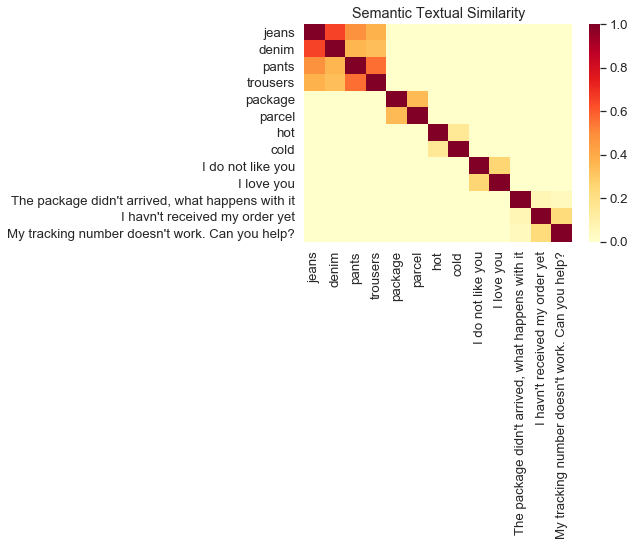

In [30]:
sim_e_c, cosine_similarities_ec = sim_exact_cross(emb1[0], emb1[0])
plot_similarity(messages, sim_e_c)


In [ ]:
t1 = time.time()
sim_a, emb1a, emb2a = sim_approx(messages[0:1], messages[2:3])
print(time.time() - t1)

In [ ]:
sim_e, emb1e, emb2e = sim_exact(messages, messages)
# plot_similarity(messages, sim_exact)

In [ ]:
sim_a
plot_similarity(messages, sim_a)

In [ ]:
sim_e_c
plot_similarity(messages, sim_e_c)

In [ ]:

# pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
# print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
#     pearson_correlation[0], pearson_correlation[1]))

In [22]:
cm.__exit__(None, None, None)

False

In [42]:
emb1e.shape

(13, 512)

In [1]:
messages

NameError: name 'messages' is not defined